# Improving Model Performance in Deployment Scenarios

## TL;DR aka the executive summary

Below, we benchmark [TorchDynamo](https://github.com/pytorch/torchdynamo) to measure the speedup it brings to `Bert` in an inference setup and compare it to traditional tools like `ONNX Runtime` and `TensorRT`.

`TorchDynamo` captures `Pytorch` computation subgraphs at the `Python` bytecode level and send them to model compilers/fusers (list available by calling `torchdynamo.list_backends()`) which will perform `kernel fusions`.

> `Kernel fusion` is a transformation of the computation graph which merges several operations into a single one. It brings speedup in both training and inference scenarios because in `eager` mode, each operation done by `Pytorch` needs to transfer data from `GPU` RAM to L1/L2 cache, performs the computation and then write the result back in the RAM. Then next operation read the result of the previous one from the `GPU` RAM, etc. On most operations (all but `matmul` and assimilated), the computation is almost instantaneous, what takes time is to transfer from and to the `GPU` RAM. By merging several operations into a single one, kernel fusion remove the memory transfer bottleneck. Basically, the first operation will load data from RAM to cache, then do the computation, then pass the result directly to the second one, etc. until at the end the output is finally written back to memory.

Traditional kernel fusion means rewrite in `CUDA` several parts of the graph. There are plenty of custom kernels for NLP models in both `ONNX Runtime` and `TensorRT`. Of course, the holy grail would be to generate the optimized code automatically. Many work on that, `TVM` being the most famous project. Pytorch `nvfuser` and `nnc` do also that work, for simple cases at least (like merging several elementwise operations). Another approach is to simplify the write of custom kernel like [Triton](https://github.com/openai/triton).

The big change brought by `TorchDynamo` compared to traditional approaches is the ease of use: just add a single line of Python code and get the benefit!
As written before, `TorchDynamo` doesn't do the compilation itself, it "*just*" capture and transfer the computation graph to one of many backends.
If a backend doesn't support the graph, it will fallback to the original Python bytecode.  
Because of the design, the worst case is that it brings no improvement, but it doesn't crash.

With the experiments ran below, we learned that:

* `TorchDynamo` provides a strong end-to-end performance boost on `Bert` in both latency and throughput sensitive scenarios;
* It's on par with `ONNX Runtime`! (**when model specific kernels are not used**);
* Its use with `nvfuser` / `nnc` is completely transparent for the user, it's basically a context manager, it requires close to no configuration, it doesn't require you to fix the graph for unsupported operators, it's very fast at performing the fusions, there is no specific need to care about the optimized sub-graph cache, etc.;
* new `nvfuser` already provides slightly more efficient optimized graph than `nnc`, it's interesting because the merging strategies in `nvfuser` are designed to be as generic as possible (not at the `Aten` operator level, more at the operator family level, with the family being a group of operators sharing the same kind of device memory access patterns), meaning that it will be easier to make it evolve... (if curious, you may check [this](https://www.nvidia.com/en-us/on-demand/session/gtcspring21-s31952/));
* Some backends which are emphasized by the Meta team are not really working for now, in particular `fx2trt` (for `TensorRT`) doesn't let you provide shape profiles (for dynamic shapes), one of its authors confirmed us it will be doable soon;
* It's missing some important features like real `mixed precision` support (today recommended ways to do `FP16` is to call `.half()`, it won't work well with models trained in `FP32` or `BF16` among others);

## What kind of model improvement would we be interested into?

Performance depends of the scenario: latency or throughput sensitive.
Among other things, batch size depends highly on it:

- in `latency` scenario (online job usually), inference is done with batch size 1 as by definition it implies the least computation;
- in `throughput` scenario (batch offline jobs usually), one needs to batch data points until the GPU is saturated, meaning it’s fully busy with computation. There is usually a point when making a batch bigger doesn't bring any advantage. We want to find this optimal batch size.

For that reason, graphs below only display information required to compare things for these two scenarios and not more.

## Why not just use `TorchScript`?

`TorchScript` is the first thing to come in mind in `Pytorch` world when you think optimization for inference deployment, but:

- `TorchScript` has no dynamic shape support when used with `tracing` and `scripting` would require most `transformer` implementations rework. Without dynamic shape support, we would burn our graph optimizations in `padding`;
- `TorchScript` maybe not future proof, or at least not get the attention it needs ([ex. from Pytorch team manager @nvidia](https://github.com/rwightman/pytorch-image-models/issues/1244?utm_source=pocket_mylist#issuecomment-1130075034) among many other signals),

It happens than `TorchDynamo` team has released a prototype.  
It definitely misses support of basic stuff... but sounds promising enough to be studied.

Because a speedup alone is not enough, it has been put into perspective by comparing its results with more traditional tooling, aka `ONNX Runtime` and `TensorRT`.

In [1]:
! nvidia-smi

Mon Jul 11 18:42:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:03:00.0  On |                  N/A |
| 36%   46C    P8    41W / 350W |    366MiB / 24576MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Installation and imports

To rerun the notebook, you may run `jupyter nbconvert --execute --clear-output benchmark.ipynb`.


In [2]:
# have to be installed at the very end
# ! pip3 install git+https://github.com/pytorch/torchdynamo.git@ee1b62f4947a94a87c288f38711de76bfaa2ffd4 --no-cache-dir

In [3]:
from typing import Dict

import numpy as np
import torch
from onnxruntime import GraphOptimizationLevel

from transformers import AutoModel, PreTrainedModel
from transformer_deploy.backends.ort_utils import convert_fp16
from transformer_deploy.backends.onnx_utils import save_onnx

from dynamo_utils import (
    benchmark,
    check_output,
    get_dynamo_optimizer,
    get_onnx_inference,
    get_pytorch_inference,
    get_pytorch_input,
    plot_benchmarks,
    print_pytorch_profile,
    get_tensorrt_inference, 
    seq_lengths,
)

import gc
import tensorrt as trt
from tensorrt.tensorrt import ICudaEngine, Logger, Runtime
import onnx
from transformer_deploy.backends.trt_utils import build_engine, save_engine

## Benchmark setup

* load models (we chose vanilla Bert, its output is of little use in most usual scenarios)
* generate random input to check the output of each optimized model (in real life you would use a real dataset)

In [4]:
assert torch.cuda.is_available(), "requires GPU"

torch.random.manual_seed(123)

# for benchmarking, should be ok to use vanilla model (for real tasks it will have some layers on top)
model_name = "bert-base-uncased"
onnx_path = f"{model_name}.onnx"
onnx_fp16_path = f"{model_name}_fp16.onnx"
tensorrt_batch_1 = f"{model_name}_batch_1.plan"
tensorrt_batch_32 = f"{model_name}_batch_32.plan"

all_timings: Dict[str, np.ndarray] = dict()
inputs_pytorch: Dict[str, torch.Tensor] = get_pytorch_input(size=(1, 32))
input_names = list(inputs_pytorch.keys())

In [5]:
pytorch_model: PreTrainedModel = AutoModel.from_pretrained(pretrained_model_name_or_path=model_name).eval().cuda()

with torch.inference_mode():
    output_pytorch = pytorch_model(**inputs_pytorch)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Benchmarking

### Baseline

To simplify things, each model is wrapped in an inference function following a common interface.
Inference function is responsible for synchronizing host and GPU, performing the actual inference, and measuring latency.
Measures are done in seconds with `time.perf_counter()`.

The `benchmark` function takes the inference function as input, performs the warmup, executes each measure 5 times, takes the median, and builds an array of all measures.

Shape of data points measured for each setup:

In [6]:
from dynamo_utils import shapes_to_test
import json

# Dict[batch, List[seq_len]]:
print(json.dumps(shapes_to_test, indent=4))

{
    "1": [
        16,
        64,
        128,
        256,
        384,
        512
    ],
    "8": [
        16,
        64,
        128,
        256,
        384,
        512
    ],
    "16": [
        16,
        64,
        128,
        256,
        384,
        512
    ],
    "32": [
        16,
        64,
        128,
        256,
        384,
        512
    ],
    "64": [
        16,
        64,
        128,
        256,
        384,
        512
    ],
    "128": [
        16,
        64,
        128,
        256,
        384,
        512
    ],
    "256": [
        16,
        64,
        128,
        256,
        384,
        512
    ]
}


Below we run benchmark on the baseline that will be used to compute the speedup of each option.

In [7]:
pytorch_fp32_inference = get_pytorch_inference(model=pytorch_model, context_managers=[torch.inference_mode()])
all_timings["pytorch fp32"] = benchmark(fn=pytorch_fp32_inference)
baseline_timings = all_timings["pytorch fp32"]

### PyTorch with FP16

First graph modification we want to test is adding cast (to FP16) nodes to the graph.  
It's done through [Automatic Mixed Precision](https://pytorch.org/docs/stable/amp.html) from `Pytorch`.  
`AMP` is a conservative tool, unlike a simple call to `.half()` on the model, it will cast to `FP32` parts of the graph where an operator may output out of FP16 range values (more on that [here](https://pytorch.org/docs/stable/amp.html#cuda-op-specific-behavior)).

Let's remind that `GPU`s are devices very good at parallelization.  
In particular memory access is hidden (done in parallel) by computation when there is enough computation to do.  
Therefore, depending of the computation load, some operators are memory bandwidth bounded (aka the latency is mostly made by reading and writing memory), it's the case of element-wise operators, and others are computation bounds, it's mainly `matmul` and assimilated operators.

As explained above, latency sensitive scenarios are supposed to be run at batch size 1 (at least in extreme cases) and better benefit from kernel fusion.  
Throughput sensitive scenarios are supposed to be run in batch, the only remaining question being which size.  

> In this report we have simplified the things by not using an inference server, etc.

We can see two effects in the graph below:
* speedup at seq len 64 is higher than at 16, it's a bit unexpected and probably due to `AMP` overhead;
* at batch size 1, there is no speedup at all, the overhead is bigger than the gain (if any). 2 main sources of overhead are the `AMP` mechanism itself and the cast operations it implies;
* as expected, speedup tends to decrease with seq len. `FP16` operations made 2 things faster: `matmul` AND memory bandwidth bounded operations. With longer seq lengths, on all batch sizes (but 1), computation load increases and dominates the inference latency, we only benefit from accelerated `matmul` (memory bandwidth bounded operations don't scale as fast as `matmul` in transformer models);
* the throughput graph reflects perfectly what we see in the speedup one: a convergence of performances when the GPU is busy to compute;
* for throughput sensitive scenario, if the seq len is longer than 256 tokens, there is no need to use very large batch size (16 gives same results than 128, meaning we have saturated the `GPU`).

> most of these analyses are valuable for the other try below, they won't be repeated

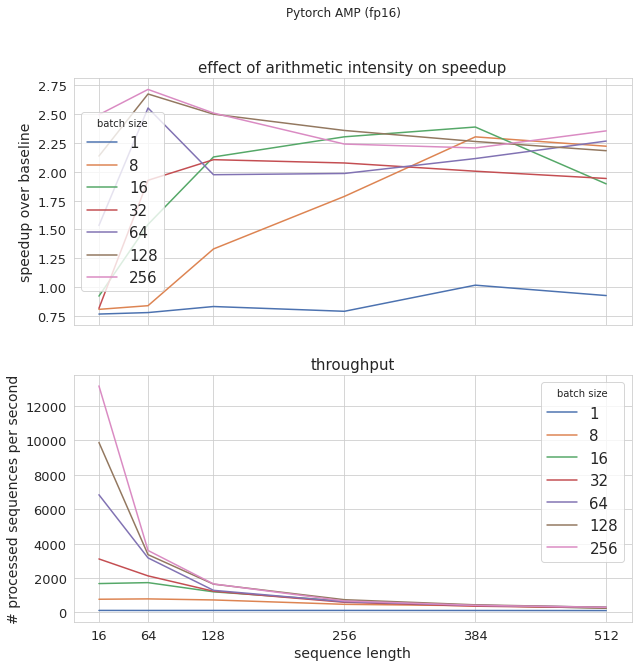

In [8]:
pytorch_fp16_inference = get_pytorch_inference(
    model=pytorch_model, context_managers=[torch.inference_mode(), torch.autocast(device_type="cuda")]
)
check_output(fn=pytorch_fp16_inference, inputs=inputs_pytorch, expected_outputs=output_pytorch)
all_timings["pytorch amp fp16"] = benchmark(fn=pytorch_fp16_inference)

plot_benchmarks(latencies=all_timings["pytorch amp fp16"], title="Pytorch AMP (fp16)", baseline=baseline_timings)

### TorchDynamo with nvfuser

As written above, using `TorchDynamo` is basically adding a context manager to the inference code... this level of easiness is really refreshing!  
Below we are using `nvfuser`, which is the default fuser for `GPU`s since `Pytorch` 1.12.0 (aka 12 days ago at the time of the writing).

> `ofi` stands for "*optimized for inference*") as this fuser can also be used for training (outside the scope of this project).

Unlike FP16, the benefits of kernel fusion are bigger on batch size 1, it's expected as there is no overhead in fusion (compiled graphs are cached by `TorchDynamo`) and memory bandwidth bounded operations are the one benefiting from fusion. The slightly improved speedup on longer sequence may be due to `TorchDynamo` caching effect only, it can also be observed when used with `eager` backend (no fuser at all). However it would require deeper analysis for confirmation.

Regarding throughput sensitive scenario, again, with long sequence lengths, batch size almost doesn't matter.

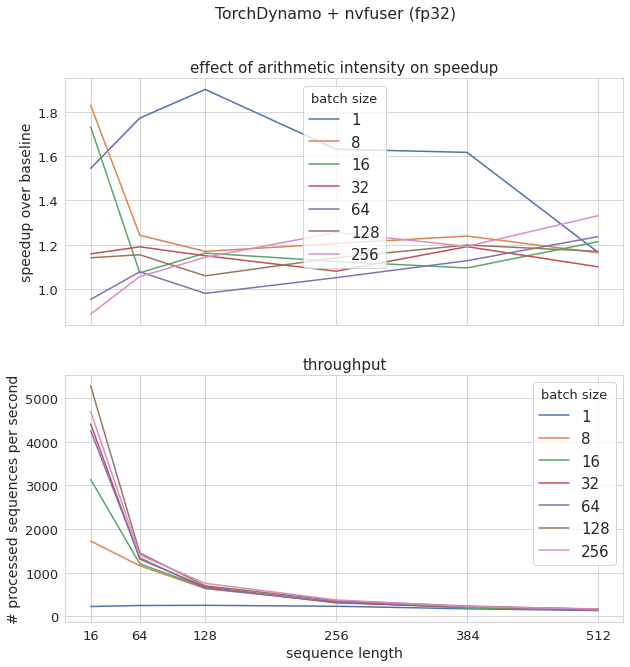

In [9]:
# WARNING: dynamo doesn't support inference_mode() context manager, uses no_grad instead
nvfuser_ofi_inference = get_pytorch_inference(
    model=pytorch_model, context_managers=[torch.no_grad(), get_dynamo_optimizer(name="nvfuser_ofi")]
)
check_output(fn=nvfuser_ofi_inference, inputs=inputs_pytorch, expected_outputs=output_pytorch)
all_timings["pytorch nvfuser_ofi fp32"] = benchmark(nvfuser_ofi_inference)

plot_benchmarks(
    latencies=all_timings["pytorch nvfuser_ofi fp32"], title="TorchDynamo + nvfuser (fp32)", baseline=baseline_timings
)

### TorchDynamo with nnc

`nnc` fuser shows same patterns than `nvfuser`. Still the new fuser offers slightly better performances.

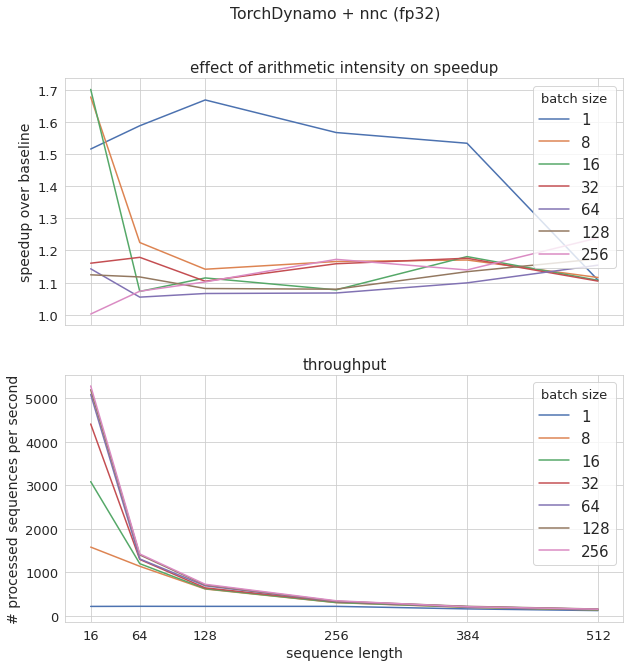

In [10]:
nnc_ofi_inference = get_pytorch_inference(
    model=pytorch_model, context_managers=[torch.no_grad(), get_dynamo_optimizer(name="nnc_ofi")]
)
check_output(fn=nnc_ofi_inference, inputs=inputs_pytorch, expected_outputs=output_pytorch)
all_timings["pytorch nnc_ofi fp32"] = benchmark(nnc_ofi_inference)


plot_benchmarks(
    latencies=all_timings["pytorch nnc_ofi fp32"], title="TorchDynamo + nnc (fp32)", baseline=baseline_timings
)

### TorchDynamo with nvfuser in FP16

Calling `.half()` on the model will cast all the tensors to `FP16`.  
It's definitly not the best idea to do that (risk of out of range values), but it's the only way to test the fuser in `FP16`.

Anyway, the performance are surprisingly strong, even better than `ONNX Runtime` in `FP16` (see below).  
To dig a bit more we need to understand what is from the conversion with `.half()` and what is due to the fuser.  
Let's see the next graph...


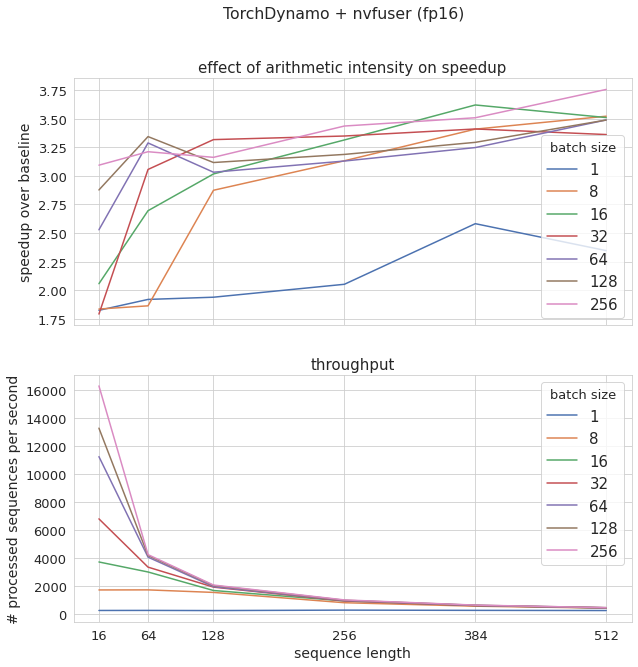

In [11]:
import copy

pytorch_model_fp16 = copy.deepcopy(pytorch_model).half()
assert pytorch_model.dtype == torch.float32
assert pytorch_model_fp16.dtype == torch.float16
pytorch_model = pytorch_model.cpu()

nvfuser_ofi_fp16_inference = get_pytorch_inference(
    model=pytorch_model_fp16, context_managers=[torch.no_grad(), get_dynamo_optimizer(name="nvfuser_ofi")]
)
check_output(fn=nvfuser_ofi_fp16_inference, inputs=inputs_pytorch, expected_outputs=output_pytorch)
all_timings["pytorch nvfuser_ofi fp16"] = benchmark(nvfuser_ofi_fp16_inference)

plot_benchmarks(
    latencies=all_timings["pytorch nvfuser_ofi fp16"], title="TorchDynamo + nvfuser (fp16)", baseline=baseline_timings
)

Below we benchmark the `FP16` model and can see the speedup is significantly better than with `AMP` (for reasons described above, no cast and no `AMP` mechanism overhead).  
We will need to wait for `AMP` support on `TorchDynamo` to get fair measures.

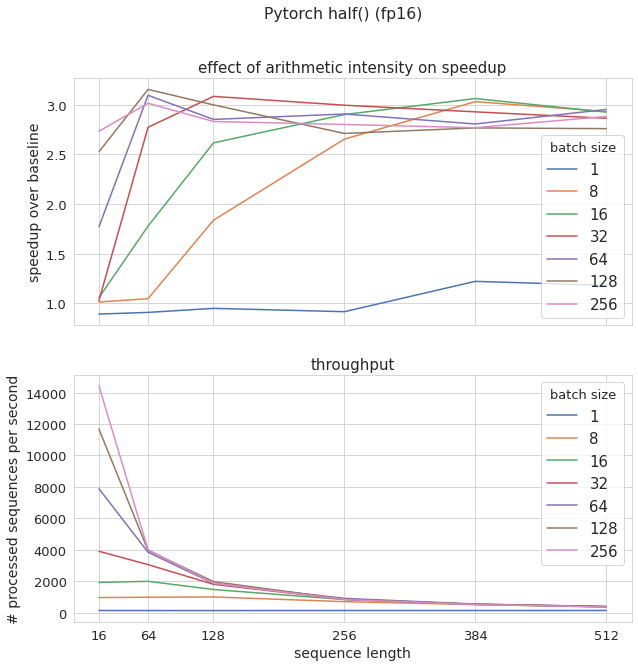

In [12]:
pytorch_fp16_inference = get_pytorch_inference(model=pytorch_model_fp16, context_managers=[torch.no_grad()])
check_output(fn=pytorch_fp16_inference, inputs=inputs_pytorch, expected_outputs=output_pytorch)
all_timings["pytorch fp16"] = benchmark(pytorch_fp16_inference)

plot_benchmarks(latencies=all_timings["pytorch fp16"], title="Pytorch half() (fp16)", baseline=baseline_timings)


del pytorch_model_fp16
gc.collect()
torch.cuda.empty_cache()

### ONNX Runtime without any optimization

`ONNX Runtime` is one of the most well known and used backends for inference.  
During the conversion of eager `PyTorch` models to static graph, a first graph simplification is applied through the use of `constant folding`.  
We make sure that we define dynamic axes for all inputs and outputs.

In [13]:
pytorch_model = pytorch_model.cuda()
output_names = list(output_pytorch.keys())
dynamic_axis = {name: {0: "batch", 1: "seq_len"} for name in input_names + output_names}

# we apply first graph modification by using constant folding
with torch.no_grad():
    torch.onnx.export(
        model=pytorch_model,
        args=tuple(inputs_pytorch.values()),
        f=onnx_path,
        opset_version=13,
        do_constant_folding=True,  # replace constant expressions
        input_names=input_names,
        output_names=output_names,
        dynamic_axes=dynamic_axis,  # declare dynamic axis for each input / output
        training=torch.onnx.TrainingMode.EVAL,  # always put the model in evaluation mode
        verbose=False,
    )
pytorch_model = pytorch_model.cpu()
gc.collect()
torch.cuda.empty_cache()

First evaluation of the model with `ONNX Runtime` is done without any optimization.  
Indeed, by default `ONNX Runtime` applies basic kernel fusion (mainly elementwise operations) and aggressive `constant folding` and here we disable this behavior.  

We can see that it's not a very good idea to disable out of the box optimizations as the performances may be worse than just running `Pytorch`.

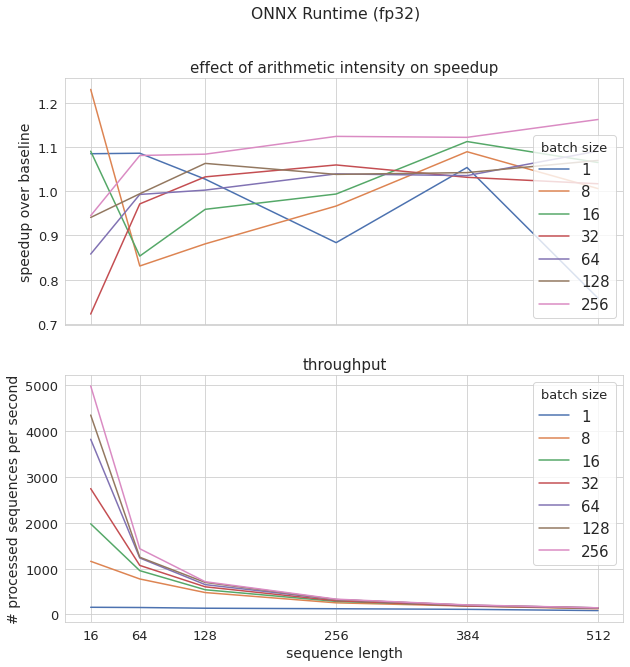

In [14]:
onnx_no_opt_inference = get_onnx_inference(
    onnx_path=onnx_path, optimization_level=GraphOptimizationLevel.ORT_DISABLE_ALL
)
check_output(fn=onnx_no_opt_inference, inputs=inputs_pytorch, expected_outputs=output_pytorch)
all_timings["onnx fp32"] = benchmark(fn=onnx_no_opt_inference)
del onnx_no_opt_inference  # free CUDA memory

plot_benchmarks(latencies=all_timings["onnx fp32"], title="ONNX Runtime (fp32)", baseline=baseline_timings)

### ONNX Runtime with optimization

Here we use the same model as above, but we apply default optimizations.  
Speedup is close but not as strong as the one offered by `TorchDynamo`, by itself it is remarkable!  
Indeed, `ONNX Runtime` is quite mature, written in C++ with close to no overhead, etc. where `TorchDynamo` is a prototype living in Python world (many parts the byte level stuff is in `C` and backends in `C++`).  
Of course, it has many other advantages over `TorchDynamo`, starting with you don't need `Python` to run it.

One thing out of the scope of this project which may have made the difference would be the use of the model specific kernel fusion implemented in `ONNX Runtime`.  
For now, `TorchDynamo` has not such thing, but sure it will come.


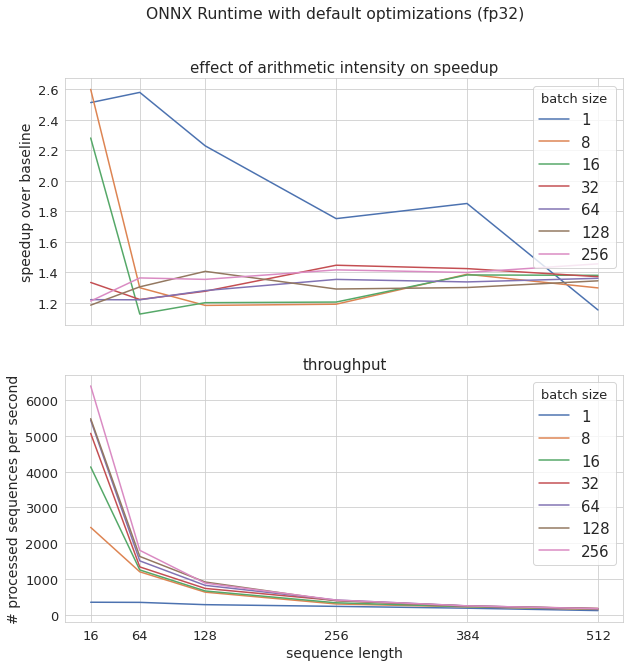

In [15]:
# it will use the optimized model
onnx_opt_inference = get_onnx_inference(onnx_path=onnx_path, optimization_level=GraphOptimizationLevel.ORT_ENABLE_ALL)
check_output(fn=onnx_opt_inference, inputs=inputs_pytorch, expected_outputs=output_pytorch)
all_timings["onnx fp32 opt"] = benchmark(fn=onnx_opt_inference)
del onnx_opt_inference  # free CUDA memory

plot_benchmarks(
    latencies=all_timings["onnx fp32 opt"],
    title="ONNX Runtime with default optimizations (fp32)",
    baseline=baseline_timings,
)

### ONNX Runtime with optimization in FP16

Mixed precision is a generic graph transformation that allows using `FP16` for inference by adding some cast nodes here and there.  
We use a custom function below which, unlike the usual one, won't perform any model specific kernel fusion.  
`ONNX Runtime` core source code shows that it adds some cast nodes on **some** sensitive operators, it's less conservative than `AMP` but is Okish for average transformer models (if such a thing exists...).  

Speedup is really strong, even on long sequence length.  
That's definitely something one may want to use in its real life application.

In [16]:
onnx_fp16 = convert_fp16(onnx_path, [])
save_onnx(proto=onnx_fp16, model_path=onnx_fp16_path)  # remove and serialize

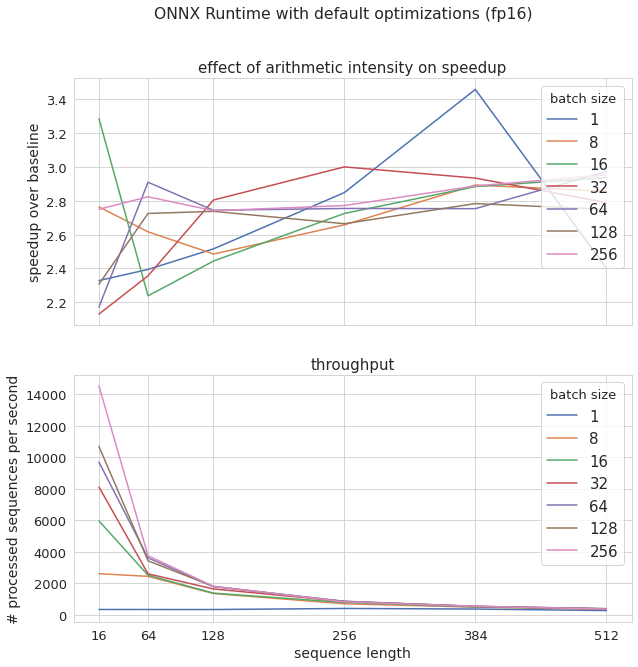

In [17]:
onnx_fp16_inference = get_onnx_inference(
    onnx_path=onnx_fp16_path, optimization_level=GraphOptimizationLevel.ORT_ENABLE_ALL
)
check_output(fn=onnx_fp16_inference, inputs=inputs_pytorch, expected_outputs=output_pytorch)
all_timings["onnx fp16 opt"] = benchmark(fn=onnx_fp16_inference)
del onnx_fp16_inference  # free CUDA memory

plot_benchmarks(
    latencies=all_timings["onnx fp16 opt"],
    title="ONNX Runtime with default optimizations (fp16)",
    baseline=baseline_timings,
)

### TensorRT

`TensorRT` is a delicate beast. For instance, it doesn't like to have 2 dynamic axis at the same time, otherwise it will complain:

```log
[TRT] [W] Myelin graph with multiple dynamic values may have poor performance if they differ. Dynamic values are:
[TRT] [W]  (# 1 (SHAPE input_ids))
[TRT] [W]  (# 0 (SHAPE attention_mask))
```

> `Myelin` is one of the many optimization engine inside `TensorRT`, and is mostly used for Transformer.

Below, we keep the batch size fixed, the sequence length is dynamic.
As we can see, the speedup is really strong, which is partly explained that it uses model specific kernels.
As expected, the effect is the stronges on cases where the model is memory bandwidth bounded.

The surprise is that speedup is really good on large batch too! Kudo to `TensorRT` authors for this.

In [18]:
model = onnx.load(onnx_path)
save_onnx(proto=model, model_path="clean.onnx", clean=True)  # remove and serialize

trt_logger: Logger = trt.Logger(trt.Logger.ERROR)
runtime: Runtime = trt.Runtime(trt_logger)

In [19]:
engine: ICudaEngine = build_engine(
    runtime=runtime,
    onnx_file_path="clean.onnx",
    logger=trt_logger,
    min_shape=(1, 16),
    optimal_shape=(1, 384),
    max_shape=(1, 512),
    fp16=True,
    int8=False,
)
save_engine(engine=engine, engine_file_path=tensorrt_batch_1)
del engine  # free CUDA memory
gc.collect()

8040

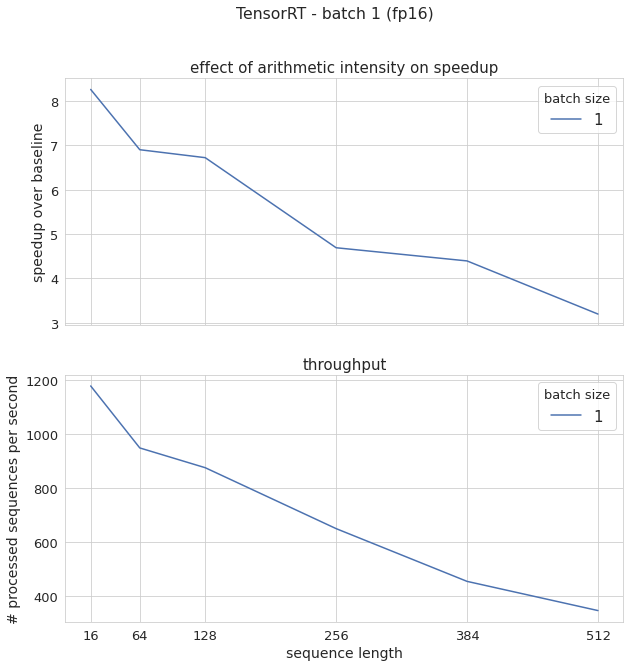

In [20]:
trt_opt_inference = get_tensorrt_inference(runtime=runtime, plan_path=tensorrt_batch_1)
check_output(fn=trt_opt_inference, inputs=inputs_pytorch, expected_outputs=output_pytorch)
all_timings["trt batch 1 fp16"] = benchmark(fn=trt_opt_inference, shapes={1: seq_lengths})
del trt_opt_inference  # free CUDA memory

plot_benchmarks(
    latencies=all_timings["trt batch 1 fp16"],
    title="TensorRT - batch 1 (fp16)",
    baseline=baseline_timings[0:1, :],
    batches=[1],
)

In [21]:
engine: ICudaEngine = build_engine(
    runtime=runtime,
    onnx_file_path="clean.onnx",
    logger=trt_logger,
    min_shape=(32, 16),
    optimal_shape=(32, 384),
    max_shape=(32, 512),
    fp16=True,
    int8=False,
)
save_engine(engine=engine, engine_file_path=tensorrt_batch_32)
del engine  # free CUDA memory
gc.collect()

5746

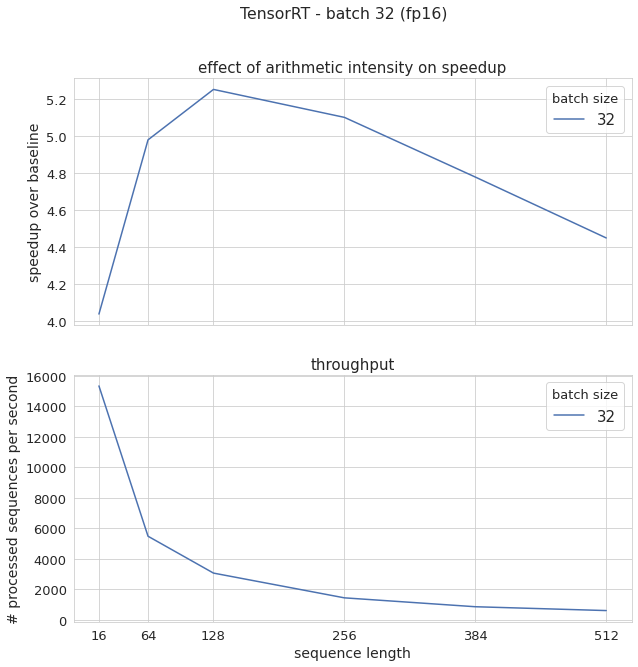

In [22]:
trt_opt_inference = get_tensorrt_inference(runtime=runtime, plan_path=tensorrt_batch_32)
all_timings["trt batch 32 fp16"] = benchmark(fn=trt_opt_inference, shapes={32: seq_lengths})
del trt_opt_inference  # free CUDA memory

plot_benchmarks(
    latencies=all_timings["trt batch 32 fp16"],
    title="TensorRT - batch 32 (fp16)",
    baseline=baseline_timings[3:4, :],
    batches=[32],
)

## Profiling TorchDynamo fused model

We can see in the list of operators some merged ones (the ones prefixed by `fused_` followed by the name of the fused operators, ex. `fused_add_add`).

> Profiling is done at the end of this notebook as after its use, there is a CPU overhead on any Pytorch operation, even if the profiler is supposed to be off.

In [23]:
pytorch_model = pytorch_model.cuda()
print_pytorch_profile(fn=nvfuser_ofi_inference, inputs=inputs_pytorch)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us     160.094ms        35.10%     160.094ms       3.508us           0 b           0 b           0 b           0 